In [2]:
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt

out_dir = "out"

## Shuffle and Project

In [2]:
def result_to_acc(result):
    prob_err = {}
    for exp_id, exp_res in result.items():
        prob_err[exp_id] = {
            "prob": np.mean(exp_res["prob"]),
            "err": np.mean(exp_res["err"]),
        }
    return prob_err


def fetch_shuffle_acc(model_name, method="diagonal"):
    path_to_dir = os.path.join(out_dir, model_name)
    files = os.listdir(path_to_dir)

    qks = []
    ovs = []
    for file in files:
        if file.endswith(f"{method}.json"):
            if file.startswith("shuffle_result_QK"):
                qks.append(file)
            if file.startswith("shuffle_result_OV"):
                ovs.append(file)
    pattern = re.compile(r"_(\d+)_")

    qk = sorted(qks, key=lambda x: int(pattern.search(x).group(1)), reverse=True)[0]
    ov = sorted(ovs, key=lambda x: int(pattern.search(x).group(1)), reverse=True)[0]

    qk_acc = result_to_acc(json.load(open(os.path.join(path_to_dir, qk), "r")))
    ov_acc = result_to_acc(json.load(open(os.path.join(path_to_dir, ov), "r")))

    return {"qk": qk_acc, "ov": ov_acc}


def fetch_project_acc(model_name, method="diagonal"):
    path_to_dir = os.path.join(out_dir, model_name)
    files = os.listdir(path_to_dir)

    ovs_true = []
    ovs_false = []
    qks_true = []
    qks_false = []

    for file in files:
        if file.endswith(f"{method}.json"):
            if file.startswith("proj_QK_proj_True"):
                qks_true.append(file)
            if file.startswith("proj_QK_proj_False"):
                qks_false.append(file)
            if file.startswith("proj_OV_proj_True"):
                ovs_true.append(file)
            if file.startswith("proj_OV_proj_False"):
                ovs_false.append(file)

    pattern = re.compile(r"_(\d+)_")

    qk_true = sorted(
        qks_true, key=lambda x: int(pattern.search(x).group(1)), reverse=True
    )[0]
    qk_false = sorted(
        qks_false, key=lambda x: int(pattern.search(x).group(1)), reverse=True
    )[0]
    ov_true = sorted(
        ovs_true, key=lambda x: int(pattern.search(x).group(1)), reverse=True
    )[0]
    ov_false = sorted(
        ovs_false, key=lambda x: int(pattern.search(x).group(1)), reverse=True
    )[0]

    return {
        "qk_true": result_to_acc(
            json.load(open(os.path.join(path_to_dir, qk_true), "r"))
        ),
        "qk_false": result_to_acc(
            json.load(open(os.path.join(path_to_dir, qk_false), "r"))
        ),
        "ov_true": result_to_acc(
            json.load(open(os.path.join(path_to_dir, ov_true), "r"))
        ),
        "ov_false": result_to_acc(
            json.load(open(os.path.join(path_to_dir, ov_false), "r"))
        ),
    }

In [3]:
model_name = "gemma-7b"
shuffle = fetch_shuffle_acc(model_name)
project = fetch_project_acc(model_name)

shuffle

{'qk': {'original': {'prob': 0.899455459680443, 'err': 0.036444444444444446},
  'random baseline 1': {'prob': 0.4490552086649273, 'err': 0.4351111111111111},
  'random baseline 2': {'prob': 0.5014430214017337,
   'err': 0.34044444444444444},
  'random baseline 3': {'prob': 0.5128369831766146,
   'err': 0.32355555555555554},
  'random baseline 4': {'prob': 0.8077955042272358,
   'err': 0.09066666666666667},
  'random baseline 5': {'prob': 0.7343159146407805, 'err': 0.1537777777777778},
  'random baseline 6': {'prob': 0.2566409989642922, 'err': 0.6457777777777778},
  'random baseline 7': {'prob': 0.5012906533550975, 'err': 0.332},
  'random baseline 8': {'prob': 0.47929411710749165,
   'err': 0.3888888888888889},
  'random baseline 9': {'prob': 0.563392100440043, 'err': 0.27066666666666667},
  'random baseline 10': {'prob': 0.5707179739724278,
   'err': 0.26666666666666666},
  'shuffle 1': {'prob': 0.8679699026504091, 'err': 0.06088888888888889},
  'shuffle 2': {'prob': 0.812173626057237

## Distribution of Diagonal and Subspace

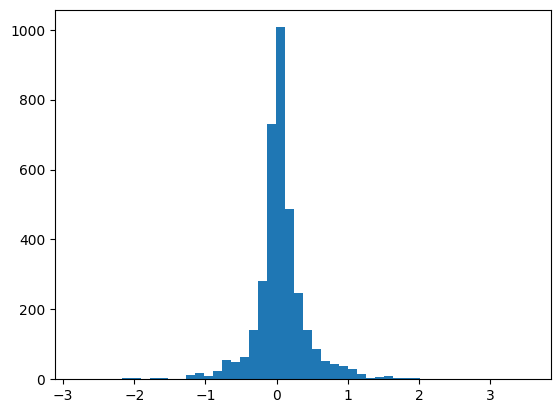

In [8]:
def fetch_diagonal(model_name):
    with open(f"{out_dir}/{model_name}/diagonal_random.json") as f:
        d = json.load(f)
    
    return np.array([dd["score"] for dd in d])


plt.hist(fetch_diagonal("gpt2"), bins=50)
plt.show()

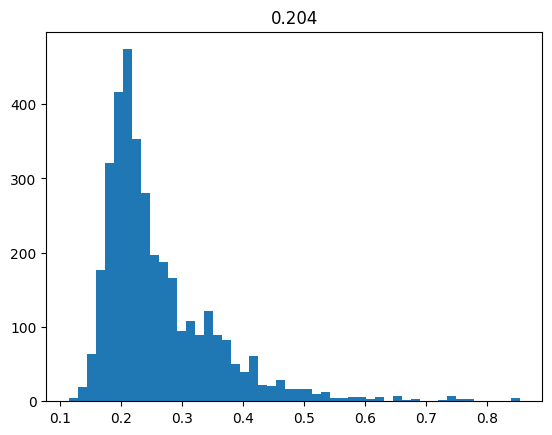

In [13]:
def fetch_subspace(model_name, return_baseline=False):
    with open(f"{out_dir}/{model_name}/subspace_IH_PTH_K60_largest_random.json") as f:
        d = json.load(f)
    
    baseline = d[0]["baseline"]
    stats = np.array([dd["score"] for dd in d[1:]])
    if return_baseline:
        return stats, baseline
    
    return stats

stats, baseline = fetch_subspace("gpt2", return_baseline=True)
plt.hist(stats, bins=50)
plt.title(round(baseline, 3))
plt.show()